In [ ]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (Compose, LoadImaged, AddChanneld, Lambdad, Transpose, MapTransform, Activations, AsDiscrete, RandGaussianSmoothd, CropForegroundd, SpatialPadd, ScaleIntensityd, ToTensord, RandSpatialCropd, CenterSpatialCropd,
                              Rand3DElasticd, RandAffined, RandZoomd, Spacingd, Orientationd, Resized, ThresholdIntensityd, RandShiftIntensityd, BorderPadd, RandGaussianNoised, RandAdjustContrastd, NormalizeIntensityd, RandFlipd, ScaleIntensityRanged, RandCropByPosNegLabeld)
from my_transform import MyCrop
from monai.data import CacheDataset, DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle
import sys

# set_determinism(seed=0) # Set deterministic training for reproducibility
num_workers = 0 if sys.platform.startswith('win32') else 4
# torch.cuda.is_available()

# Determine the training set and validation set used by the pretrained model
with open(os.path.join("model","3D",'fold_1_batch_train_metric.pickle'), 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    batch_metric = pickle.load(f)

batch_metric['batch_train_loss'] = np.array(batch_metric['batch_train_loss'])

for i,j in enumerate(batch_metric['batch_train_metric']):
    batch_metric['batch_train_metric'][i] = j.cpu().numpy()
batch_metric['batch_train_metric'] = np.array(batch_metric['batch_train_metric'])

batch_filename = batch_metric['batch_filename']
batch_train_loss = batch_metric['batch_train_loss']
batch_train_metric = batch_metric['batch_train_metric']


train_images = sorted(
    glob.glob(os.path.join("data", "imagesTr", "*.nii.gz")))
# train_labels = sorted(
#     glob.glob(os.path.join( "labelsTr_modified", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join("data", "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = np.array(data_dicts)[tuple([batch_train_metric>=0.85])].tolist(), np.array(data_dicts)[tuple([batch_train_metric<0.85])].tolist()
train_files.__len__(),val_files.__len__()
train_files, val_files = train_files[:2], val_files[:]

patch_size, image_spacing = (224, 224, 40), (0.8, 0.8, 2.5)

train_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=["image", "label"], pixdim=image_spacing,
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # 灰度值阶段在[-96,215]之间
        # ThresholdIntensityd(keys=['image'], threshold=-100, above=True, cval=-100),  # Threshold CT
        # ThresholdIntensityd(keys=['image'], threshold=240, above=False, cval=240),

        # NormalizeIntensityd(keys=['image']),                                          # augmentation
        # ScaleIntensityd(keys=['image']),                                              # intensity
        ScaleIntensityRanged(
            keys=["image"], a_min=-96, a_max=215,
            b_min=0.0, b_max=1.0, clip=True),
        # crop CropForeground
        CropForegroundd(keys=['image', 'label'], source_key='image'),

        # pad if the image is smaller than patch
        SpatialPadd(keys=['image', 'label'],
                    spatial_size=patch_size, method='end'),

        # RandSpatialCropd(keys=['image', 'label'], roi_size=patch_size, random_size=False),
        # CenterSpatialCropd(keys=['image', 'label'], roi_size=patch_size),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
        Lambdad(keys=["image", "label"],
                func=lambda x:x.transpose(0, 3, 2, 1)),
        ToTensord(keys=['image', 'label'])
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=["image", "label"], pixdim=image_spacing,
                 mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        ScaleIntensityRanged(
            keys=["image"], a_min=-96, a_max=215,
            b_min=0.0, b_max=1.0, clip=True),

        # crop CropForeground
        # CropForegroundd(keys=['image', 'label'], source_key='label', select_fn=lambda x: x > 0, margin=100),

        # CropForegroundd(keys=['image', 'label'], source_key='image'),
        # SpatialPadd(keys=['image', 'label'],
        #             spatial_size=patch_size, method='end'),

        # Find where the tumor is located and crop the image
        MyCrop(
            keys=["image", "label"],
            source_key="label",
            select_fn=lambda x: x > 0, 
            margin=0,
            spatial_size=patch_size,
        ),

        CenterSpatialCropd(keys=["image", "label"],roi_size = patch_size),
        SpatialPadd(keys=['image', 'label'], spatial_size=patch_size, method= 'end'),  # pad if the image is smaller than patch

        Lambdad(keys=["image", "label"],
                func=lambda x:x.transpose(0, 3, 2, 1)),

        ToTensord(keys=['image', 'label'])
    ]
)

In [2]:
# train_ds = CacheDataset(
#     data=train_files, transform=train_transforms,
#     cache_rate=1, num_workers=6)
train_ds = Dataset(
    data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0,
                          pin_memory=torch.cuda.is_available())


# val_ds = CacheDataset(
#     data=val_files, transform=val_transforms, 
#     cache_rate=1, num_workers=6)
val_ds = Dataset(
    data=val_files, transform=val_transforms)
# val_ds = Dataset(
#     data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                        pin_memory=torch.cuda.is_available())

# load model

In [ ]:
from network_trainer import NetworkTrainer

In [ ]:
continue_train = True
using_pretrained = True
modify=True
num_classes=3

if(continue_train != True):
    final_epoch = -1
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_train_loss_all = []
    epoch_val_loss_all = []
    metric_all = []
    lr = []
    if using_pretrained:
        preload = os.path.join('model', '3D', 'model_final_checkpoint.model')
    else:
        preload = os.path.join('results', 'best_metric_model_128.pth')

else:
    with open(os.path.join('settings', 'data_199.pickle'), 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data_0 = pickle.load(f)

    final_epoch = data_0['final_epoch']
    val_interval = data_0['val_interval']
    best_metric = data_0['best_metric']
    best_metric_epoch = data_0['best_metric_epoch']
    epoch_train_loss_all = data_0['epoch_train_loss_all']
    epoch_val_loss_all = data_0['epoch_val_loss_all']
    metric_all = data_0['metric_all']
    lr = data_0['lr']
    if using_pretrained:
        preload = os.path.join('model', '3D', 'model_final_checkpoint.model')
    else:
        preload = os.path.join('results', 'best_metric_model_128.pth')


In [ ]:
import collections
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(preload)['state_dict']

for k, v in state_dict.items():
    name = k 
    # skip
    # if k[:11] == "seg_outputs" and k[12]!='4':
    #     new_state_dict[name] = torch.zeros([j if i!=1 else j+32 for i,j in enumerate(v.shape)])
    #     new_state_dict[name][:,:v.shape[1],:,:,:] = v
    # else:
    #     new_state_dict[name] = v

    if k[:11] == "seg_outputs":
        new_state_dict[name] = torch.zeros([j if i!=0 else num_classes for i,j in enumerate(v.shape)])
        # print(name,new_state_dict[name].shape)
        if num_classes==3:
            new_state_dict[name][0] = v[0,:,:,:,:]
            new_state_dict[name][1] = v[1,:,:,:,:]
            new_state_dict[name][2] = v[2,:,:,:,:]
        else:
            new_state_dict[name][0] = v[0,:,:,:,:]
            new_state_dict[name][1] = v[2,:,:,:,:] + v[1,:,:,:,:]
    else:
        new_state_dict[name] = v

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
else:
    print("WARNING!!! You are attempting to run training on a CPU (torch.cuda.is_available() is False). This can be VERY slow!")

Unet = NetworkTrainer(num_classes=num_classes, using_UNET_3D=True, epoch=final_epoch+1,deep_supervision=False)
Unet.initialize()
Unet.device = 'cpu'
Unet.network.to(Unet.device);
Unet.update_lr(epoch=final_epoch+1)

if preload is not None:
    # model.load_state_dict(torch.load(preload))
    checkpoint = torch.load(preload)
    if using_pretrained:
        if modify==True:
            Unet.load_state_dict(new_state_dict)
        else:
            Unet.load_state_dict(checkpoint['state_dict'])
    else:
        Unet.load_state_dict(checkpoint)


learning rate = 0.0007440
model has been loaded


# Compress model

In [8]:
from copy import deepcopy
import torch
import os
import collections
from collections import OrderedDict
import tensorly as tl
import numpy as np
from tensorly.tt_tensor import validate_tt_rank, TTTensor

def cal_model_size(new_state_dict):
    size = 0
    for key,value in new_state_dict.items():
        if type(value) == collections.OrderedDict:
            for key,value in value.items():
                size += value.nelement() * value.element_size()
                print(value.nelement())
        elif type(value) == list:
            for i in value:
                size += i.nelement() * i.element_size()
        else:
            size += value.nelement() * value.element_size()
    return size
checkpoint = torch.load(os.path.join('model', '3D', 'model_final_checkpoint.model'))['state_dict']


In [12]:
for key,value in checkpoint.items():
    print(value.element_size())
    break
cal_model_size(checkpoint)

4


123035136

In [13]:
123035136/4

30758784.0

# Test

In [7]:
# from plot import test_plot_2,test_plot,plot

test_val_data = first(val_loader)
# test_train_data = first(train_loader)
val_image = test_val_data["image"]
# train_image = test_train_data["image"]
val_label = test_val_data["label"]
# train_label = test_train_data["label"]

In [7]:
from copy import deepcopy
from loss_functions.dice_loss import SoftDiceLoss
from torch import nn
from my_compress import convert_numpy,cal_model_size,compress_conv_,compress_conv,compress,my_tensor_train,compress_conv_tt_,compress_conv_tt
import tensorly as tl

tl.set_backend('pytorch')

calculate_dice = SoftDiceLoss(apply_nonlin=lambda x: nn.functional.softmax(
    x, 1), batch_dice=True, do_bg=False, smooth=1e-5)
device = Unet.device

checkpoint = torch.load(os.path.join('model', '3D', 'model_final_checkpoint.model'))['state_dict']
# to_save = compress_conv(checkpoint,compress_rate=0.6);

You are using an old version of PyTorch (1.7.1). We recommend upgrading to a newest one, e.g. >1.8.0.


In [17]:
tl.set_backend('pytorch')
checkpoint = torch.load(os.path.join('model', '3D', 'model_final_checkpoint.model'))['state_dict']

dice_svd = compress_svd['dice_svd']
model_size_svd = []

for compress_rate in np.array(range(3,-1,-1))/10:
    comressed_checkpoint_ = compress_conv_(checkpoint,compress_rate=compress_rate)
    comressed_checkpoint = compress_conv(checkpoint,compress_rate=compress_rate)
    model_size_svd.append(cal_model_size(comressed_checkpoint))

    Unet.load_state_dict(comressed_checkpoint_)

    with torch.no_grad():
        Unet.network.eval()
        dice_svd_one = []
        for val_data in val_loader:
            val_image = val_data["image"]
            val_label = val_data["label"]
            
            val_outputs = Unet.network(val_image)
            dice_svd_one.append(-calculate_dice(val_outputs,val_label))

            print("finish",val_data['image_meta_dict']['filename_or_obj'],compress_rate)

        dice_svd[str(compress_rate)]=dice_svd_one


model has been loaded
finish ['data\\imagesTr\\pancreas_021.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_024.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_035.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_040.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_042.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_043.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_056.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_086.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_089.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_092.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_094.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_095.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_098.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_109.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_110.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_111.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_114.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_119.nii.gz'] 0.3
finish ['data\\imagesTr\\pancreas_138.nii.gz'] 0.3
finish ['

In [34]:
# compress_tt = {
#             'dice_tt': dice_tt,
#             'model_size_tt': model_size_tt,
#         }

# with open('compress_tt.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(compress_tt, f, pickle.HIGHEST_PROTOCOL)

# with open(os.path.join('compress_tt.pickle'), 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     compress_tt = pickle.load(f)

# compress_svd = {
#             'dice_svd': compress_svd['dice_svd'],
#             'model_size_svd': compress_svd['model_size_svd'],
#         }

# with open('compress_svd.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(compress_svd, f, pickle.HIGHEST_PROTOCOL)

# with open(os.path.join('compress_svd.pickle'), 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     compress_svd = pickle.load(f)

In [31]:
for i in compress_svd['dice_svd'].keys():
    print(i,torch.tensor(compress_svd['dice_svd'][i]).mean())

1.0 tensor(0.6654)
0.9 tensor(0.6635)
0.8 tensor(0.6632)
0.7 tensor(0.6589)
0.6 tensor(0.6462)
0.5 tensor(0.6343)
0.4 tensor(0.5506)
0.3 tensor(0.2595)
0.2 tensor(0.0317)
0.1 tensor(0.0472)
0.0 tensor(0.0480)


In [33]:
compress_svd['model_size_svd'] 

[181312856,
 102438412,
 71575624,
 51510268,
 37179572,
 26529600,
 18350380,
 11979696,
 6932496,
 3038016,
 257680]

In [35]:
# torch.tensor(compress_tt['dice_tt']['0.5'])-torch.tensor(dice_svd['0.5'])

In [16]:
comressed_checkpoint = compress_conv(checkpoint,compress_rate=0.7)
comressed_checkpoint_ = compress_conv_(checkpoint,compress_rate=0.7)

In [25]:
'seg_outputs'.__len__()

11

In [11]:
# i = 0
# for regex in checkpoint.keys():
#     if regex[-6:]=="weight" and regex[-11:-6]!='norm.' and regex[0:11]!='seg_outputs':
#         shape=checkpoint[regex].shape
#         print(regex)
#         print(shape)
#         i = i+1
#         # max = shape[0]
#         # min = shape[0]
#         # for s in shape:
#         #     if s > max:
#         #         max = s
#         #     if s < min:
#         #         min = s
#         # print(checkpoint[regex].view(-1,max*min).shape)
# i

In [ ]:
# for i in comressed_checkpoint['conv_blocks_localization.0.0.blocks.0.conv.weight']:
#     print(i.shape)

In [23]:
cal_model_size(checkpoint)

123035136

In [12]:
# for regex in checkpoint.keys():
#     if regex[-6:]=="weight" and regex[-11:-6]!='norm.':
#             print(regex)

In [22]:
val_image.shape

torch.Size([1, 1, 40, 224, 224])

In [55]:
tl.set_backend('pytorch')

dice_tt = []
model_size_tt = []
test_val_data['image_meta_dict']['filename_or_obj']

for compress_rate in np.array(range(10,-1,-1))/10:
    comressed_checkpoint_ = compress_conv_tt_(checkpoint,compress_rate=compress_rate)
    comressed_checkpoint = compress_conv_tt(checkpoint,compress_rate=compress_rate)
    Unet.load_state_dict(comressed_checkpoint_)
    with torch.no_grad():
        predict = Unet.network(val_image[None,0].to('cpu'))
        dice_tt.append(-calculate_dice(predict,val_label))
        model_size_tt.append(cal_model_size(comressed_checkpoint))
    print("finish",compress_rate)

In [12]:
dice_svd = []
model_size_svd = []
test_val_data['image_meta_dict']['filename_or_obj']
for compress_rate in np.array(range(0,11))/10:
    comressed_checkpoint_ = compress_conv_(checkpoint,compress_rate=compress_rate,mode='maxmin')
    comressed_checkpoint = compress_conv(checkpoint,compress_rate=compress_rate,mode='maxmin')
    Unet.load_state_dict(comressed_checkpoint_)
    with torch.no_grad():
        predict = Unet.network(val_image[None,0].to('cpu'))
        dice_svd.append(-calculate_dice(predict,val_label))
        model_size_svd.append(cal_model_size(comressed_checkpoint))
    print("finish",compress_rate)

model has been loaded
finish 0.0
model has been loaded
finish 0.1
model has been loaded
finish 0.2
model has been loaded
finish 0.3
model has been loaded
finish 0.4
model has been loaded
finish 0.5
model has been loaded
finish 0.6
model has been loaded
finish 0.7
model has been loaded
finish 0.8
model has been loaded
finish 0.9
model has been loaded
finish 1.0


In [46]:
compress_svd['dice_svd'].keys()

dict_keys(['1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1', '0.0'])

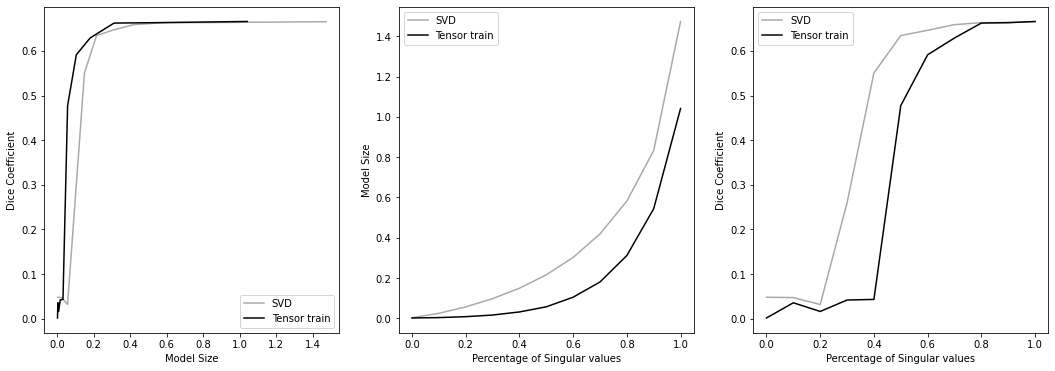

In [57]:
import matplotlib.pyplot as plt
original_size = cal_model_size(checkpoint)

model_size_svd = compress_svd['model_size_svd'] 
dice_svd = []
for i in compress_svd['dice_svd'].keys():
    dice_svd.append(torch.tensor(compress_svd['dice_svd'][i]).mean()) 

model_size_tt = compress_tt['model_size_tt'] 
dice_tt = []
for i in compress_tt['dice_tt'].keys():
    dice_tt.append(torch.tensor(compress_tt['dice_tt'][i]).mean()) 


plt.figure("train", (18, 6))
plt.subplot(1, 3, 3)
# plt.title("Dice Coefficient")
# x = [i + 1 for i in range(len(epoch_train_loss_all),350)]
x = [i/10 for i in range(10,-1,-1)]
y1 = [i.numpy() for i in dice_svd]
y2 = [i.numpy() for i in dice_tt]
# y3 = [i.numpy() for i in dice_svd_0]
# y1 = [i/original_size for i in model_size_svd]

plt.xlabel("Percentage of Singular values")
plt.ylabel("Dice Coefficient")
plt.plot(x, y1,'darkgray',label='SVD')
plt.plot(x, y2, 'black',label='Tensor train')
# plt.plot(x, y3, 'black',label='dice_svd_0')
plt.legend()

plt.subplot(1, 3, 2)
# plt.title("Model Size")
# x = [i + 1 for i in range(len(epoch_train_loss_all),350)]
x = [i/10 for i in range(10,-1,-1)]
y1 = [i/original_size for i in model_size_svd]
y2 = [i/original_size for i in model_size_tt]
# y3 = [i/original_size for i in model_size_svd_0]
# y2 = [i.numpy() for i in dice_svd]

plt.xlabel("Percentage of Singular values")
plt.ylabel("Model Size")
plt.plot(x, y1,'darkgray',label='SVD')
plt.plot(x, y2, 'black',label='Tensor train')
# plt.plot(x, y3, 'black',label='model_size_svd_0')
plt.legend()

plt.subplot(1, 3, 1)
# plt.title("Dice/Size")
# x = [i + 1 for i in range(len(epoch_train_loss_all),350)]
x1 = [i/original_size for i in model_size_svd]
y1 = [i.numpy() for i in dice_svd]
x2 = [i/original_size for i in model_size_tt]
y2 = [i.numpy() for i in dice_tt]
plt.xlabel("Model Size")
plt.ylabel("Dice Coefficient")
plt.plot(x1, y1,'darkgray',label='SVD')
plt.plot(x2, y2, 'black',label='Tensor train')
plt.legend()
plt.savefig('compress_final.svg')

In [156]:
# predict
Unet.load_state_dict(checkpoint)
import gc
gc.collect()
with torch.no_grad():
    predict_2 = Unet.network(val_image[None,0].to('cpu'))
-calculate_dice(predict_2[0],val_label)

model has been loaded


tensor(0.7412)

In [157]:
# compressed
Unet.load_state_dict(comressed_checkpoint_)
import gc
gc.collect()
with torch.no_grad():
    predict = Unet.network(val_image[None,0].to('cpu'))
-calculate_dice(predict[0],val_label)

model has been loaded


tensor(0.7060)

In [42]:
AsDiscrete(to_onehot=False,argmax=True)(predict[0]).shape

torch.Size([1, 1, 40, 224, 224])

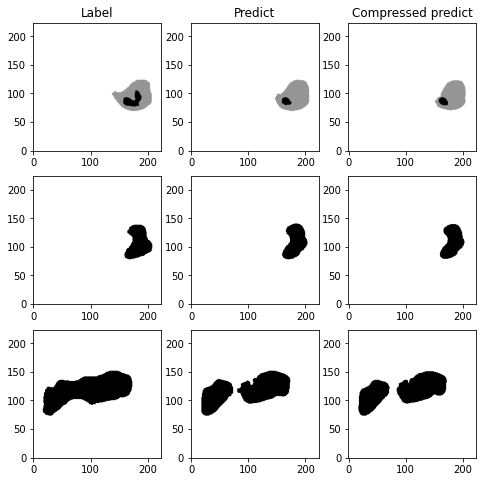

In [180]:
import matplotlib.pyplot as plt
# slice = 2
row = 3
column = 3
# for slice in range(0,40,10):
#     # plt.figure("check", (12, 6))
#     plt.subplot(row, column, 1)
#     plt.imshow(val_label.squeeze().permute(0,2,1)[slice].cpu().detach().numpy())

#     plt.subplot(row, column, 2)
#     plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict[0]).squeeze().permute(0,2,1)[slice].cpu().detach().numpy())

#     plt.subplot(row, column, 3)
#     plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict_2[0]).squeeze().permute(0,2,1)[slice].cpu().detach().numpy())
#     # plt.show()
slice=12
plt.figure("check", (8, 8))

plt.subplot(row, column, 1)
# plt.axis('off') 
plt.title("Label")
plt.imshow(val_label.squeeze().permute(0,1,2)[slice].cpu().detach().numpy(),cmap='Greys',origin='lower')

plt.subplot(row, column, 2)
# plt.axis('off') 
plt.title("Predict")
plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict_2[0]).squeeze().permute(0,1,2)[slice].cpu().detach().numpy(),'Greys',origin='lower')

plt.subplot(row, column, 3)
# plt.axis('off') 
plt.title("Compressed predict")
plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict[0]).squeeze().permute(0,1,2)[slice].cpu().detach().numpy(),'Greys',origin='lower')

for i in range(row-1):
    plt.subplot(row, column, i*3+4)
    # plt.axis('off') 
    plt.imshow(val_label.squeeze().permute(0,1,2)[slice+(i+1)*slice].cpu().detach().numpy(),'Greys',origin='lower')

    plt.subplot(row, column, i*3+5)
    # plt.axis('off') 
    plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict_2[0]).squeeze().permute(0,1,2)[slice+(i+1)*slice].cpu().detach().numpy(),'Greys',origin='lower')

    plt.subplot(row, column, i*3+6)
    # plt.axis('off') 
    plt.imshow(AsDiscrete(to_onehot=False,argmax=True)(predict[0]).squeeze().permute(0,1,2)[slice+(i+1)*slice].cpu().detach().numpy(),'Greys',origin='lower')
    plt.savefig('compress_0.svg')

In [164]:
val_label.squeeze().permute(0,1,2)[10]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

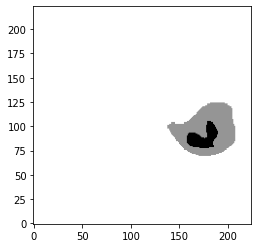

In [178]:
plt.imshow(val_label.squeeze().permute(0,1,2)[12].cpu().detach().numpy(),'Greys',origin='lower')


In [ ]:
# comressed_checkpoint_numpy = convert_numpy(comressed_checkpoint)
# torch.save(comressed_checkpoint_numpy,os.path.join("compressed_model.pth"))